Target: help out the sellers to list their items faster by suggesting a price for which they could sell their items

In [108]:
import os
import sys
import warnings
import math

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.pre_proc.utils import (convert_strings_to_categories,
                                get_time_related_columns,
                                replace_categorical_features_to_numerical_codes,
                                replace_numerical_missing_values_with_medians)

from src.models.utils import get_readable_model_scores, rmse

In [109]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

### Reading pre_proc data

In [110]:
df_raw = pd.read_parquet('../data/prepared_data.parquet', engine='pyarrow')

In [111]:
#Somehow I need to do object convertion to category again, after read_parquet.
df_raw = convert_strings_to_categories(df_raw)

In [112]:
# Concentrate on sold items
df_raw = df_raw[df_raw.days_till_sell.notnull()]

In [113]:
target = 'listing_price_local'

### Descriptive statistics of the target

In [114]:
df_raw[target].describe()

count    122194.000000
mean         12.948721
std          30.151083
min           0.000000
25%           5.000000
50%           8.000000
75%          14.000000
max        1000.000000
Name: listing_price_local, dtype: float64

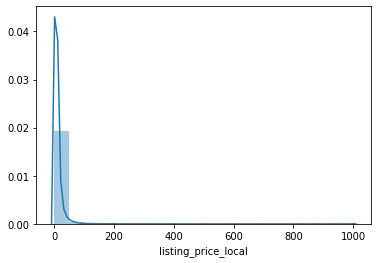

In [115]:
sns.distplot(df_raw[target], bins = 20);

In [116]:
hist, bin_edges = np.histogram(df_raw[target], bins = 20)
hist / hist.sum(), bin_edges

(array([9.70170385e-01, 2.03774326e-02, 4.23097697e-03, 1.90680393e-03,
        9.41126406e-04, 4.41920225e-04, 4.17369102e-04, 3.27348315e-04,
        2.29143820e-04, 1.06388202e-04, 1.39123034e-04, 1.06388202e-04,
        9.82044945e-05, 2.45511236e-05, 8.18370787e-05, 4.09185394e-05,
        3.27348315e-05, 6.54696630e-05, 3.27348315e-05, 2.29143820e-04]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000.]))

Target `listing_price_local` is from interval `[0:1000]`, but 97% of selling prices are from `[0:50]` interval and 99% of selling prices are from `[0:100]`. This variable is shewed to the right with high peak. Due to I will remove outliers.

In [117]:
df_raw = df_raw[df_raw.listing_price_local < 150]

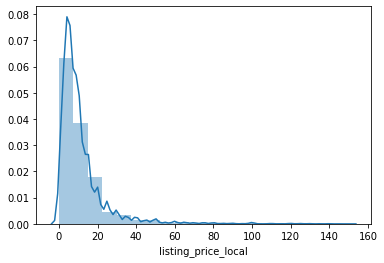

In [118]:
sns.distplot(df_raw[target], bins = 20);

It is useful to try to apply log transformation to the target in order to get normal distribution.

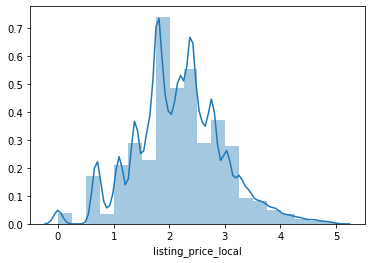

In [119]:
sns.distplot(np.log(df_raw[target] + 1), bins = 20);

### Relationship with categorical variables

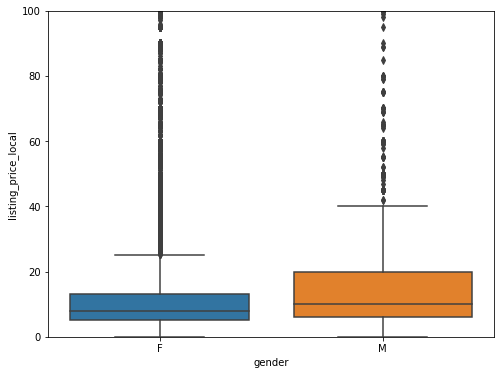

In [120]:
var = 'gender'
data = pd.concat([df_raw[target], df_raw[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=100);

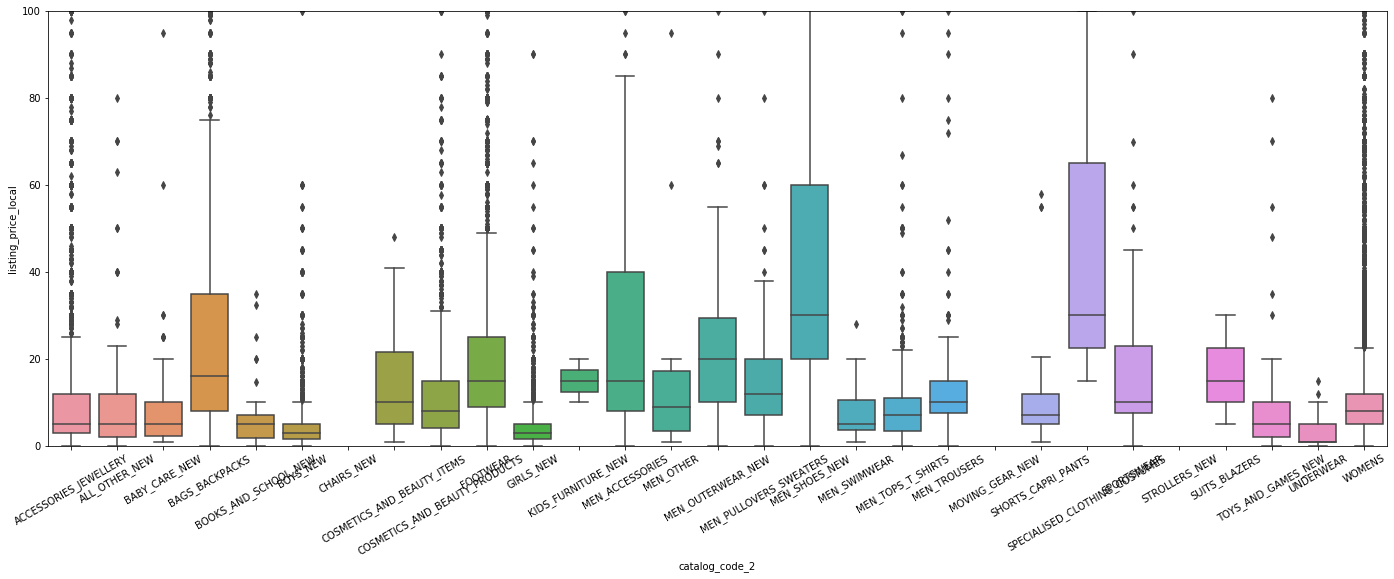

In [121]:
var = 'catalog_code_2'
data = pd.concat([df_raw[target], df_raw[var]], axis=1)
f, ax = plt.subplots(figsize=(24, 8))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=100);

Both man and woman used to sell their items on the same price.`SPECIALISED_CLOTHING_CUSTUMES` and `MEN_SHOES_NEW` tends to be more expensive than average.

In [122]:
def initial_preprocessing_pipeline(df):
    # Remove sale_time related columns, because it is unknow during listing_price_local prediction and days till sell
    sale_time_columns = get_time_related_columns(df.columns, 'sale_time')
    train_columns = list(set(df.columns) - set(sale_time_columns) - set(['days_till_sell']))
    df = df[train_columns]
    df = pd.get_dummies(df, columns=['gender',
                                     'state',
                                     'paid_organic',
                                     'catalog_code_1',
                                     'color_primary',
                                     'package_size_code'], dummy_na=True)
    df = replace_categorical_features_to_numerical_codes(df)
    df = replace_numerical_missing_values_with_medians(df)
    return df

In [123]:
df = initial_preprocessing_pipeline(df_raw)

In [124]:
df_subset = df.sample(frac=0.4, random_state=10)
train_columns = list(set(df_subset.columns) - set([target]))

### Model selection

In [18]:
regressors = {'linear regression': LinearRegression(),
              'lasso': Lasso(),
              'elastic net': ElasticNet(),
              'decision tress': DecisionTreeRegressor(),
              'gradient boosting': GradientBoostingRegressor(),
              'xgboost regressor': XGBRegressor()}
    
results = []
for model_name, regressor in regressors.items():
    kfold = KFold(n_splits=3, random_state=21)
    cv_results = cross_val_score(regressor,
                                 df_subset[train_columns],
                                 df_subset[target],
                                 cv=kfold,
                                 scoring='neg_mean_squared_error')
    
    results.append(cv_results)
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    print(msg)

linear regression: -89.047752 (2.296058)
lasso: -90.547032 (2.521849)
elastic net: -89.936461 (2.437643)
decision tress: -150.985431 (2.080877)
gradient boosting: -76.846722 (1.680224)
[11:00:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost regressor: -76.607102 (1.560741)


I have tested several regression models and without any surprise boosting algorithms performed the best. Due to I will concentrate on xgboost model, because nowadays it is one of the best models with high accuracy and performance, which robust to outliers, doesnt need normalization, handles missing values.

### Baseline model

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df_subset[train_columns],
                                                    df_subset[target],
                                                    test_size=0.2,
                                                    random_state=10)
model = XGBRegressor(n_jobs=-1)
model.fit(X_train, y_train)
print(get_readable_model_scores(y_train, model.predict(X_train)))
print(get_readable_model_scores(y_test, model.predict(X_test)))

[14:38:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 8.225603847604324,
absolute mean: 4.778747480768322,
overpriced predictions mean: 5.8566986296486165, 
overpriced predictions count: 15874, 
underpriced predictions mean: -4.035516948807857, 
underpriced predictions count: 23023, 

RMSE: 8.886955482220493,
absolute mean: 4.9719228576397825,
overpriced predictions mean: 6.030317160481842, 
overpriced predictions count: 4024, 
underpriced predictions mean: -4.224864679313797, 
underpriced predictions count: 5701, 



### Feature selection

In [21]:
model = XGBRegressor(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = rmse(y_test, predictions)
print("RMSE: %.2f" % (accuracy))
# Fit model using each importance as a threshold
feature_importance = model.feature_importances_
thresholds = np.sort(feature_importance[feature_importance > 0])
results = []
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor(n_jobs=-1)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = rmse(y_test, predictions)
    results.append([thresh, accuracy])
    print("Thresh=%.3f, n=%d, RMSE: %.2f" % (thresh, select_X_train.shape[1], accuracy))


[11:03:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 8.90
[11:03:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.001, n=69, RMSE: 8.90
[11:04:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.002, n=68, RMSE: 8.90
[11:04:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.002, n=67, RMSE: 8.89
[11:04:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.002, n=66, RMSE: 8.89
[11:04:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.002, n=65, RMSE: 8.87
[11:04:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.002, n=64, RM

[11:10:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.016, n=14, RMSE: 8.99
[11:10:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.017, n=13, RMSE: 8.96
[11:10:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.021, n=12, RMSE: 9.07
[11:10:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.022, n=11, RMSE: 9.09
[11:10:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.022, n=10, RMSE: 9.11
[11:10:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.023, n=9, RMSE: 9.15
[11:10:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thr

Select features with treshold 0.01

In [59]:
feature_importance = rf_feat_importance(model, X_train)

In [60]:
feature_importance

cols       imp
33                       package_size_code_SMALL  0.138789
46                                    brand_mean  0.122503
205                                birthday_mean  0.054737
274                          catalog_code_3_mean  0.054226
8                                     title_mean  0.042943
191                                    title_min  0.032540
31                       package_size_code_LARGE  0.031145
60                           window_items_listed  0.026241
146                             total_items_sold  0.023407
271                                    city_mean  0.022458
214                          catalog_code_4_mean  0.021774
247                                 birthday_min  0.021022
180                               total_gmv_sold  0.016563
232                    catalog_code_1_WOMEN_ROOT  0.016259
136                            window_items_sold  0.016011
135                                    title_max  0.015889
153                              window_gmv_sold  0.014540
43                                         brand  0.014468
186                                     city_max  0.014033
14                                      city_min  0.013461
206             registration_local_timeDayofweek  0.012478
161                               local_timeHour  0.012121
195                                 birthday_max  0.012008
196              second_sale_local_timeDayofyear  0.011610
104                          window_items_bought  0.009916
98        basic_verification_local_timeDayofyear  0.009061
241                                    brand_max  0.008757
251                   second_sale_local_timeWeek  0.008262
179                                        title  0.008153
139                   registration_local_timeDay  0.007529
93                           local_timeDayofweek  0.007393
53                               local_timeMonth  0.007381
147                          catalog_code_2_mean  0.007336
230                               catalog_code_3  0.007250
67                                catalog_code_2  0.007214
123                    first_sale_local_timeHour  0.007132
92                           local_timeDayofyear  0.006931
174                           catalog_code_2_max  0.006832
111            first_listing_local_timeDayofweek  0.006644
121     first_faq_entry_view_local_timeDayofweek  0.006560
30                     registration_full_utm_min  0.006305
52                            total_items_listed  0.006275
248                  registration_local_timeHour  0.006242
76                                          size  0.006208
243             registration_local_timeDayofyear  0.006192
91                  first_listing_local_timeWeek  0.006169
125                   registration_full_utm_mean  0.005684
144                    lister_nth_day_of_listing  0.005320
252                           lister_nth_listing  0.005078
32                              total_gmv_bought  0.004879
64                       days_since_registration  0.004643
264                                    size_mean  0.004643
235                    registration_full_utm_max  0.004420
38                        catalog_code_1_BUNDLES  0.003982
263                total_negative_feedback_count  0.003970
39        first_upload_form_visit_local_timeHour  0.003804
4                                       birthday  0.003592
177                                    brand_min  0.003518
90                 days_since_user_first_listing  0.003312
207                           catalog_code_3_min  0.003077
78                           color_primary_BLACK  0.003064
115                        registration_type_max  0.002921
148           first_faq_entry_view_local_timeDay  0.002576
17                          listing_platform_max  0.002353
150                                   with_video  0.002193
170                               catalog_code_4  0.002036
41                          total_feedback_count  0.001837
15             basic_verificatio

In [61]:
important_features = feature_importance[feature_importance.imp > 0.01].cols.tolist()

In [62]:
important_features

['package_size_code_SMALL',
 'brand_mean',
 'birthday_mean',
 'catalog_code_3_mean',
 'title_mean',
 'title_min',
 'package_size_code_LARGE',
 'window_items_listed',
 'total_items_sold',
 'city_mean',
 'catalog_code_4_mean',
 'birthday_min',
 'total_gmv_sold',
 'catalog_code_1_WOMEN_ROOT',
 'window_items_sold',
 'title_max',
 'window_gmv_sold',
 'brand',
 'city_max',
 'city_min',
 'registration_local_timeDayofweek',
 'local_timeHour',
 'birthday_max',
 'second_sale_local_timeDayofyear']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_subset[important_features],
                                                    df_subset[target],
                                                    test_size=0.2,
                                                    random_state=10)
model = XGBRegressor()
model.fit(X_train, y_train)
print(get_readable_model_scores(y_train, model.predict(X_train)))
print(get_readable_model_scores(y_test, model.predict(X_test)))

[14:40:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 8.249501558285758,
absolute mean: 4.789186386604813,
overpriced predictions mean: 5.814218668265713, 
overpriced predictions count: 16023, 
underpriced predictions mean: -4.071161893772226, 
underpriced predictions count: 22874, 

RMSE: 8.880904441301306,
absolute mean: 4.976853331992314,
overpriced predictions mean: 5.979097571571961, 
overpriced predictions count: 4068, 
underpriced predictions mean: -4.256130410548084, 
underpriced predictions count: 5657, 



### Xgboost tunning

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df_subset[important_features],
                                                    df_subset[target],
                                                    test_size=0.2,
                                                    random_state=10)
model = XGBRegressor(n_estimators=500)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["mae"]
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[14:40:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:9.82197	validation_1-mae:9.83208
[1]	validation_0-mae:8.94329	validation_1-mae:8.95687
[2]	validation_0-mae:8.2115	validation_1-mae:8.22358
[3]	validation_0-mae:7.60428	validation_1-mae:7.61286
[4]	validation_0-mae:7.11656	validation_1-mae:7.12151
[5]	validation_0-mae:6.72957	validation_1-mae:6.73655
[6]	validation_0-mae:6.42085	validation_1-mae:6.4349
[7]	validation_0-mae:6.1802	validation_1-mae:6.20079
[8]	validation_0-mae:6.00056	validation_1-mae:6.0296
[9]	validation_0-mae:5.85484	validation_1-mae:5.88937
[10]	validation_0-mae:5.73278	validation_1-mae:5.77239
[11]	validation_0-mae:5.65039	validation_1-mae:5.69556
[12]	validation_0-mae:5.57921	validation_1-mae:5.63044
[13]	validation_0-mae:5.51835	validation_1-mae:5.57191
[14]	validation_0-mae:5.45547	validation_1-mae:5.51384
[15]	validation_0-mae:5.42122	validation_1-mae:5.48129
[16]	validation_0-

[147]	validation_0-mae:4.67949	validation_1-mae:4.89508
[148]	validation_0-mae:4.67774	validation_1-mae:4.89315
[149]	validation_0-mae:4.67636	validation_1-mae:4.8921
[150]	validation_0-mae:4.6746	validation_1-mae:4.89035
[151]	validation_0-mae:4.67129	validation_1-mae:4.88782
[152]	validation_0-mae:4.67071	validation_1-mae:4.88729
[153]	validation_0-mae:4.66964	validation_1-mae:4.88809
[154]	validation_0-mae:4.66616	validation_1-mae:4.8856
[155]	validation_0-mae:4.66445	validation_1-mae:4.88533
[156]	validation_0-mae:4.66343	validation_1-mae:4.88415
[157]	validation_0-mae:4.65987	validation_1-mae:4.88222
[158]	validation_0-mae:4.65698	validation_1-mae:4.88075
[159]	validation_0-mae:4.65676	validation_1-mae:4.88053
[160]	validation_0-mae:4.65515	validation_1-mae:4.88059
[161]	validation_0-mae:4.65437	validation_1-mae:4.88021
[162]	validation_0-mae:4.65175	validation_1-mae:4.87817
[163]	validation_0-mae:4.65144	validation_1-mae:4.87818
[164]	validation_0-mae:4.64942	validation_1-mae:4.8

[294]	validation_0-mae:4.48835	validation_1-mae:4.77338
[295]	validation_0-mae:4.48439	validation_1-mae:4.77019
[296]	validation_0-mae:4.48351	validation_1-mae:4.76868
[297]	validation_0-mae:4.48213	validation_1-mae:4.76832
[298]	validation_0-mae:4.48172	validation_1-mae:4.76847
[299]	validation_0-mae:4.48068	validation_1-mae:4.76789
[300]	validation_0-mae:4.48004	validation_1-mae:4.76753
[301]	validation_0-mae:4.4794	validation_1-mae:4.76772
[302]	validation_0-mae:4.47867	validation_1-mae:4.76726
[303]	validation_0-mae:4.4774	validation_1-mae:4.76735
[304]	validation_0-mae:4.47629	validation_1-mae:4.76669
[305]	validation_0-mae:4.47489	validation_1-mae:4.76523
[306]	validation_0-mae:4.47379	validation_1-mae:4.76533
[307]	validation_0-mae:4.47259	validation_1-mae:4.76449
[308]	validation_0-mae:4.47141	validation_1-mae:4.7643
[309]	validation_0-mae:4.46983	validation_1-mae:4.76384
[310]	validation_0-mae:4.46901	validation_1-mae:4.76294
[311]	validation_0-mae:4.46685	validation_1-mae:4.7

[441]	validation_0-mae:4.35018	validation_1-mae:4.70032
[442]	validation_0-mae:4.34925	validation_1-mae:4.70002
[443]	validation_0-mae:4.34806	validation_1-mae:4.69999
[444]	validation_0-mae:4.34791	validation_1-mae:4.69993
[445]	validation_0-mae:4.34748	validation_1-mae:4.70007
[446]	validation_0-mae:4.34717	validation_1-mae:4.69994
[447]	validation_0-mae:4.34671	validation_1-mae:4.70015
[448]	validation_0-mae:4.34596	validation_1-mae:4.69996
[449]	validation_0-mae:4.34529	validation_1-mae:4.69902
[450]	validation_0-mae:4.34425	validation_1-mae:4.69798
[451]	validation_0-mae:4.34381	validation_1-mae:4.69773
[452]	validation_0-mae:4.34325	validation_1-mae:4.69762
[453]	validation_0-mae:4.34259	validation_1-mae:4.69742
[454]	validation_0-mae:4.34223	validation_1-mae:4.69715
[455]	validation_0-mae:4.34175	validation_1-mae:4.69692
[456]	validation_0-mae:4.34061	validation_1-mae:4.69694
[457]	validation_0-mae:4.33967	validation_1-mae:4.69693
[458]	validation_0-mae:4.33855	validation_1-mae:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

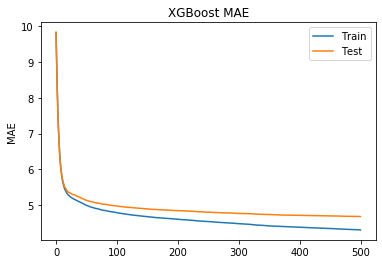

In [65]:
results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost MAE')
plt.show()

it looks like our model is learning a lot until 60 iterations, then the error decreases very slowly

### Model tunning

In [34]:
param_test1 = {
    'max_depth': range(3, 15, 3),
    'min_child_weight': range(3, 15, 3),
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(n_estimators=60), 
                        param_grid = param_test1, scoring='neg_mean_squared_error', n_jobs=-1, iid=False, cv=5)
gsearch1.fit(df_subset[important_features], df_subset[target])
gsearch1.best_params_, gsearch1.best_score_

[11:16:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 9, 'min_child_weight': 9}, -68.75930118723348)

In [66]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(n_estimators=60, max_depth=9, min_child_weight=9), 
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_subset[important_features], df_subset[target])
gsearch3.best_params_, gsearch3.best_score_

[14:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'colsample_bytree': 0.7, 'subsample': 0.8}, -67.99054204294667)

In [68]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0, 50, 10)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(n_estimators=60, max_depth=9, min_child_weight=9, colsample_bytree=0.7, subsample=0.8),
                                                 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_subset[important_features], df_subset[target])
gsearch2.best_params_, gsearch2.best_score_

[14:47:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'gamma': 0.0}, -67.99054204294667)

### Apply tuned model on subset

In [70]:
model = XGBRegressor(n_estimators=60, max_depth=9, min_child_weight=9, colsample_bytree=0.7, subsample=0.8, gamma=0)

kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model,
                          df_subset[important_features],
                          df_subset[target],
                          cv=kfold,
                          scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %.2f (%.2f)" % (results.mean(), results.std()))

[14:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
neg_mean_squared_error: -67.99 (1.22)


In [71]:
model = XGBRegressor(n_estimators=60,
                     max_depth=9,
                     min_child_weight=9,
                     colsample_bytree=0.7,
                     subsample=0.8,
                     gamma=0,
                     n_jobs=-1)

model.fit(X_train, y_train)
print(get_readable_model_scores(y_train, model.predict(X_train)))
print(get_readable_model_scores(y_test, model.predict(X_test)))

[14:49:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 6.16227269778227,
absolute mean: 3.706774392536766,
overpriced predictions mean: 4.520805076052484, 
overpriced predictions count: 16047, 
underpriced predictions mean: -3.135100415364919, 
underpriced predictions count: 22850, 

RMSE: 8.44975537276652,
absolute mean: 4.583441149683416,
overpriced predictions mean: 5.503800510104672, 
overpriced predictions count: 4080, 
underpriced predictions mean: -3.9182389901583967, 
underpriced predictions count: 5645, 



### Apply tuned model on full dataset

In [73]:
model = XGBRegressor(n_estimators=60, max_depth=9, min_child_weight=9, colsample_bytree=0.7, subsample=0.8, gamma=0)

kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model,
                          df[important_features],
                          df[target],
                          cv=kfold,
                          scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %.2f (%.2f)" % (results.mean(), results.std()))

[14:51:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
neg_mean_squared_error: -67.08 (2.07)


Model is quite robust, because measure neg_mean_squared_error 5 folds std is 2.07

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df[important_features],
                                                    df[target],
                                                    test_size=0.1,
                                                    random_state=10)
model = XGBRegressor(n_estimators=60,
                     max_depth=9,
                     min_child_weight=9,
                     colsample_bytree=0.7,
                     subsample=0.8,
                     gamma=0,
                     n_jobs=-1)

model.fit(X_train, y_train)
print(get_readable_model_scores(y_train, model.predict(X_train)))
print(get_readable_model_scores(y_test, model.predict(X_test)))

[14:54:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 6.775072857389217,
absolute mean: 3.9379923869568865,
overpriced predictions mean: 4.805157440409807, 
overpriced predictions count: 45079, 
underpriced predictions mean: -3.330244785946264, 
underpriced predictions count: 64321, 

RMSE: 7.933996663128437,
absolute mean: 4.361160237495936,
overpriced predictions mean: 5.2630382035024885, 
overpriced predictions count: 5063, 
underpriced predictions mean: -3.717397634663401, 
underpriced predictions count: 7093, 



### Error analysis

In [101]:
y_actual, y_pred = np.array(y_test), model.predict(X_test)
errors = y_actual - y_pred

In [102]:
hist, bin_edges = np.histogram(errors, bins = 20)

In [103]:
edges_and_count = {}
for i in range(len(bin_edges) - 1):
    edges_and_count[f'[{bin_edges[i]};{bin_edges[i+1]}]'] = hist[i] / np.sum(hist)

In [104]:
edges_and_count

{'[-84.29989624023438;-74.34646253585815]': 0.00016452780519907864,
 '[-74.34646253585815;-64.39302883148193]': 0.00016452780519907864,
 '[-64.39302883148193;-54.43959512710572]': 8.226390259953932e-05,
 '[-54.43959512710572;-44.486161422729495]': 8.226390259953932e-05,
 '[-44.486161422729495;-34.53272771835327]': 0.0005758473181967752,
 '[-34.53272771835327;-24.579294013977055]': 0.002796972688384337,
 '[-24.579294013977055;-14.625860309600839]': 0.01472523856531754,
 '[-14.625860309600839;-4.672426605224615]': 0.12537018756169793,
 '[-4.672426605224615;5.2810070991516085]': 0.7395524843698585,
 '[5.2810070991516085;15.234440803527832]': 0.08547219480092136,
 '[15.234440803527832;25.18787450790404]': 0.017357683448502796,
 '[25.18787450790404;35.141308212280265]': 0.00608752879236591,
 '[35.141308212280265;45.09474191665649]': 0.003290556103981573,
 '[45.09474191665649;55.0481756210327]': 0.002056597564988483,
 '[55.0481756210327;65.00160932540894]': 0.0012339585389930898,
 '[65.00160

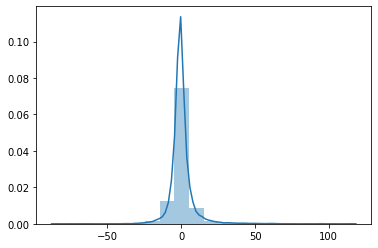

In [105]:
sns.distplot(errors, bins = 20);

74% of errors are from interval [-4.7; 5.3]. However 12.5% of errors are from [-14.6; -4.7] and 8.5% from [5.3; 15.2], these error are quite high and needs the attention. 

### Final model

In [106]:
XGBRegressor(n_estimators=60, max_depth=9, min_child_weight=9, colsample_bytree=0.7, subsample=0.8, gamma=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=9, missing=None, n_estimators=60,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [107]:
important_features

['package_size_code_SMALL',
 'brand_mean',
 'birthday_mean',
 'catalog_code_3_mean',
 'title_mean',
 'title_min',
 'package_size_code_LARGE',
 'window_items_listed',
 'total_items_sold',
 'city_mean',
 'catalog_code_4_mean',
 'birthday_min',
 'total_gmv_sold',
 'catalog_code_1_WOMEN_ROOT',
 'window_items_sold',
 'title_max',
 'window_gmv_sold',
 'brand',
 'city_max',
 'city_min',
 'registration_local_timeDayofweek',
 'local_timeHour',
 'birthday_max',
 'second_sale_local_timeDayofyear']

RMSE: 6.775072857389217,
absolute mean: 3.9379923869568865,
overpriced predictions mean: 4.805157440409807, 
overpriced predictions count: 45079, 
underpriced predictions mean: -3.330244785946264, 
underpriced predictions count: 64321, 

RMSE: 7.933996663128437,
absolute mean: 4.361160237495936,
overpriced predictions mean: 5.2630382035024885, 
overpriced predictions count: 5063, 
underpriced predictions mean: -3.717397634663401, 
underpriced predictions count: 7093, 

### Final remarks
#### Next steps would be:
* Apply ensamble methods.
* Dig deeper in error analysis.
* Apply automatic features creation tools.
* Fix data quality issues.
* Apply nlp for features creation.